In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [5]:
df= pd.read_csv('./ObesityDataSet.csv')
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [7]:
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

null_cols = null_check(df)

Column Name: Gender
Column DataType: object
Column unique values: ['Female' 'Male']
Column has null: False


Column Name: Age
Column DataType: float64
Column has null: False


Column Name: Height
Column DataType: float64
Column has null: False


Column Name: Weight
Column DataType: float64
Column has null: False


Column Name: family_history_with_overweight
Column DataType: object
Column unique values: ['yes' 'no']
Column has null: False


Column Name: FAVC
Column DataType: object
Column unique values: ['no' 'yes']
Column has null: False


Column Name: FCVC
Column DataType: float64
Column has null: False


Column Name: NCP
Column DataType: float64
Column has null: False


Column Name: CAEC
Column DataType: object
Column unique values: ['Sometimes' 'Frequently' 'Always' 'no']
Column has null: False


Column Name: SMOKE
Column DataType: object
Column unique values: ['no' 'yes']
Column has null: False


Column Name: CH2O
Column DataType: float64
Column has null: False


Column Name: SCC
C

In [8]:
def dataframe_summary(df):
    numeric_df = df.select_dtypes(include=np.number)

    # Variable details
    var_list = df.columns.to_list()
    dtype_list = df.dtypes.to_list()
    null_list = df.isnull().sum().to_list()

    # Outliers IQR
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    k = 1.5
    outlier_list = ((numeric_df < (Q1 - k * IQR)) | (numeric_df > (Q3 + k * IQR))).sum().reindex(df.columns, fill_value=0).to_list()

    # Stacking lists into a dictionary
    summary_dict = {'Variable': var_list, 'Data type': dtype_list, 'Null values': null_list, 'Outliers': outlier_list}

    # Create DataFrame
    summary_df = pd.DataFrame(summary_dict)

    # Optionally remove index from the display
    return summary_df.to_string(index=False)

In [9]:
print(dataframe_summary(df))

                      Variable Data type  Null values  Outliers
                        Gender    object            0         0
                           Age   float64            0       168
                        Height   float64            0         1
                        Weight   float64            0         1
family_history_with_overweight    object            0         0
                          FAVC    object            0         0
                          FCVC   float64            0         0
                           NCP   float64            0       579
                          CAEC    object            0         0
                         SMOKE    object            0         0
                          CH2O   float64            0         0
                           SCC    object            0         0
                           FAF   float64            0         0
                           TUE   float64            0         0
                          CALC    object

In [11]:
# Function to handle missing values
def missing_value_treatment(df, target):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]  # Preserve target column separately
        df = df.drop(columns=[target])
    else:
        target_data = None

    missing_columns = df.columns[df.isna().any()].tolist()
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = list(set(df.columns) - set(numerical_cols))

    for col in missing_columns:
        missing_ratio = df[col].isna().sum() / len(df)
        if missing_ratio <= 0.05 and len(df) > 30000:
            df.dropna(subset=[col], inplace=True)
        elif missing_ratio > 0.8:
            df.drop(columns=[col], inplace=True)
        else:
            if col in categorical_cols:
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
            else:
                imputer = IterativeImputer(max_iter=10, random_state=0)
                imputed_data = imputer.fit_transform(df[numerical_cols])
                df[numerical_cols] = pd.DataFrame(imputed_data, columns=numerical_cols)

    df.reset_index(drop=True, inplace=True)
    if target_data is not None:
        df[target] = target_data  # Reattach target column after processing
    print("Missing values treated successfully.")
    return df

# Function to handle duplicate values
def duplicate_value_treatment(df, target):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]
        df = df.drop(columns=[target])
    else:
        target_data = None

    initial_count = len(df)
    df.drop_duplicates(inplace=True)
    final_count = len(df)
    df.reset_index(drop=True, inplace=True)

    if target_data is not None:
        df[target] = target_data
    print(f"Duplicate values removed: {initial_count - final_count}")
    return df

# Function to standardize numerical columns
def data_standardization(df, target, scaling_type=1):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]
        df = df.drop(columns=[target])
    else:
        target_data = None

    num_var = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]

    if scaling_type == 1:
        scaler = StandardScaler()
    elif scaling_type == 2:
        scaler = MinMaxScaler()
    else:
        print("Invalid scaling type. Choose 1 (StandardScaler) or 2 (MinMaxScaler).")
        return df

    for col in num_var:
        df[col] = scaler.fit_transform(df[[col]]).round(2)

    if target_data is not None:
        df[target] = target_data
    print(f"Data standardized using {'StandardScaler' if scaling_type == 1 else 'MinMaxScaler'}.")
    return df

# Function to encode categorical columns
def cat_encoding(df, target):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]
        df = df.drop(columns=[target])
    else:
        target_data = None

    cat_var = [col for col in df.columns if df[col].dtype in ['object', 'category']]
    label_encoder = LabelEncoder()

    for col in cat_var:
        df[col] = label_encoder.fit_transform(df[col].astype(str))

    if target_data is not None:
        df[target] = target_data
    print("Categorical variables encoded successfully.")
    return df

# Main data preprocessing pipeline
def preprocess_data(df, target, scaling_type=1):
    print("Starting data preprocessing...")
    df = missing_value_treatment(df, target)
    df = duplicate_value_treatment(df, target)
    df = data_standardization(df, target, scaling_type)
    df = cat_encoding(df, target)
    print("Data preprocessing completed.")
    return df

# Example Usage:
target = "NObeyesdad"
df = preprocess_data(df, target, scaling_type=1)



Starting data preprocessing...
Missing values treated successfully.
Duplicate values removed: 24
Data standardized using StandardScaler.
Categorical variables encoded successfully.
Data preprocessing completed.


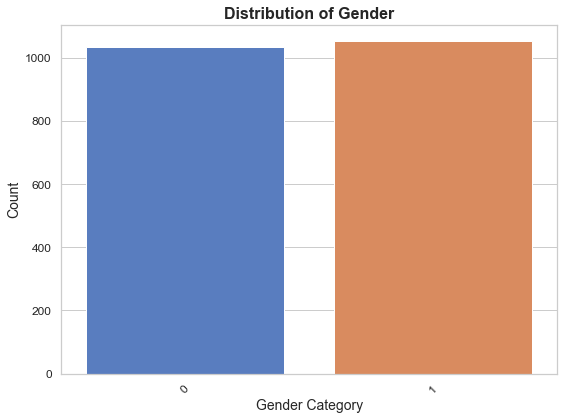

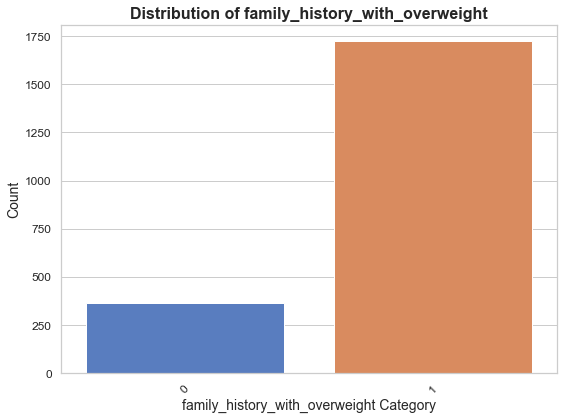

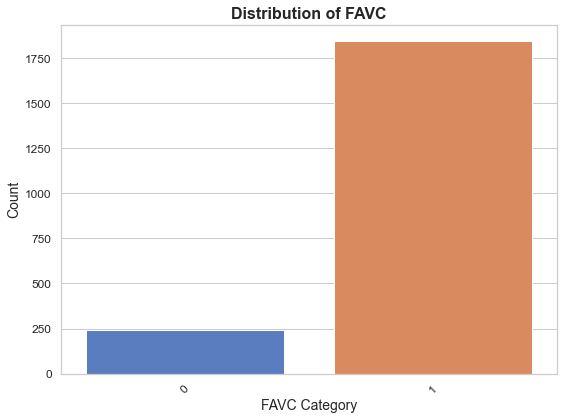

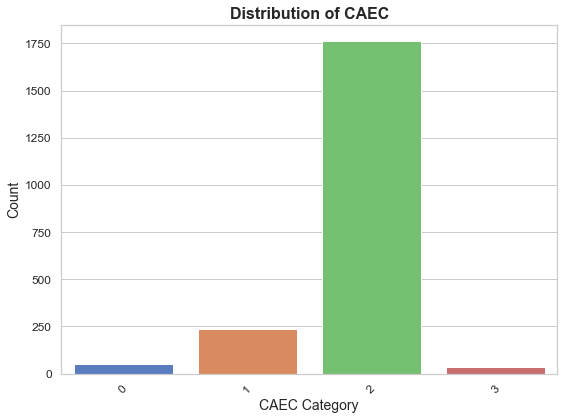

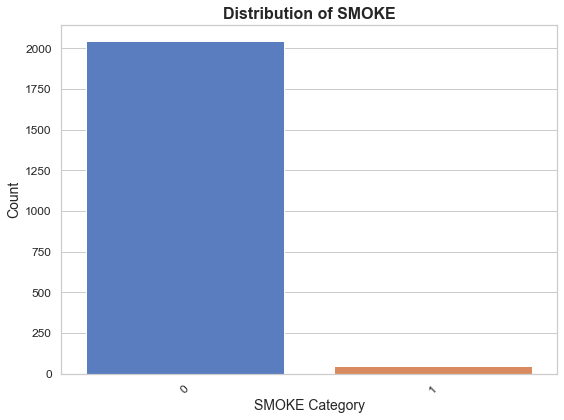

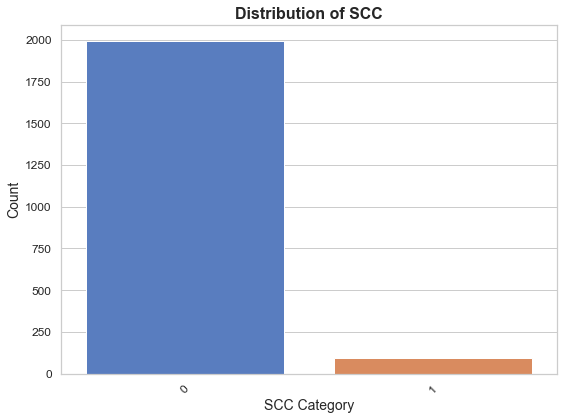

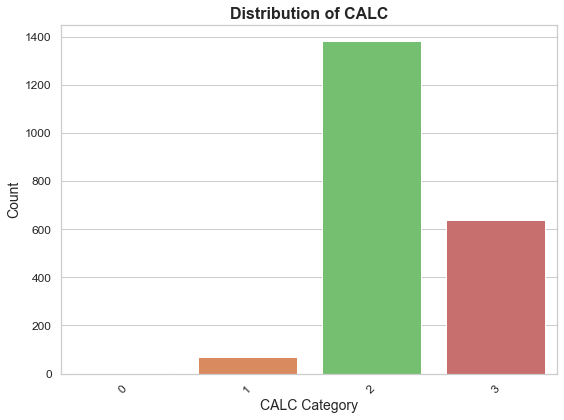

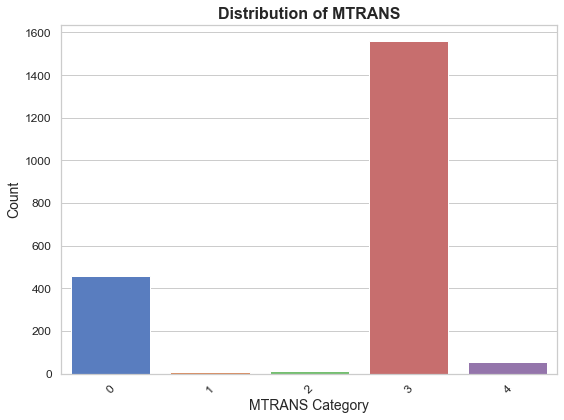

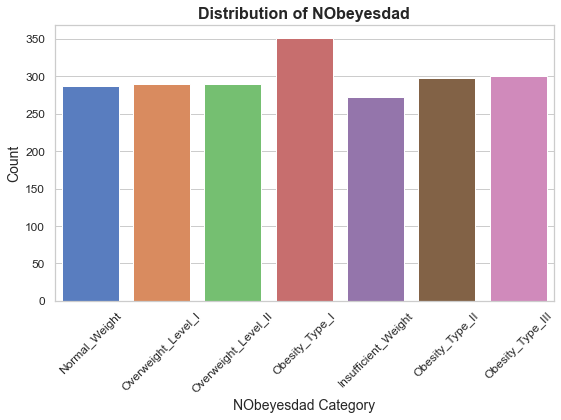

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

sns.set_theme(style="whitegrid")

for f in features:
    plt.figure(figsize=(8, 6))  # Increase figure size for better readability
    sns.countplot(x=f, data=df, palette='muted')  # Apply a muted palette for a balanced look

    # Add titles and labels
    plt.title(f'Distribution of {f}', fontsize=16, weight='bold')
    plt.xlabel(f'{f} Category', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    # Rotate x-axis labels for better readability and adjust label size
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import pandas as pd

def data_standardization(df, scaling_type=1):
    df = df.copy()
    num_var = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
    if scaling_type == 1:
        scaler = StandardScaler()
    elif scaling_type == 2:
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling_type. Use 1 for StandardScaler or 2 for MinMaxScaler.")
    df[num_var] = scaler.fit_transform(df[num_var]).round(2)
    return df

def cat_encoding(df):
    df = df.copy()
    cat_var = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col])]
    label_encoder = LabelEncoder()
    for feature in cat_var:
        df[feature] = label_encoder.fit_transform(df[feature])
    return df

df = cat_encoding(df)
df = data_standardization(df, scaling_type=2)


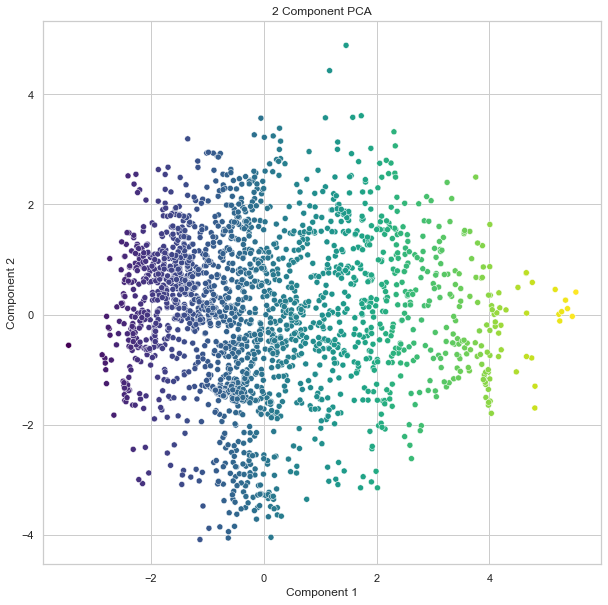

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2087 samples in 0.000s...
[t-SNE] Computed neighbors for 2087 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2087
[t-SNE] Computed conditional probabilities for sample 2000 / 2087
[t-SNE] Computed conditional probabilities for sample 2087 / 2087
[t-SNE] Mean sigma: 0.850824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.281586
[t-SNE] KL divergence after 300 iterations: 1.333133


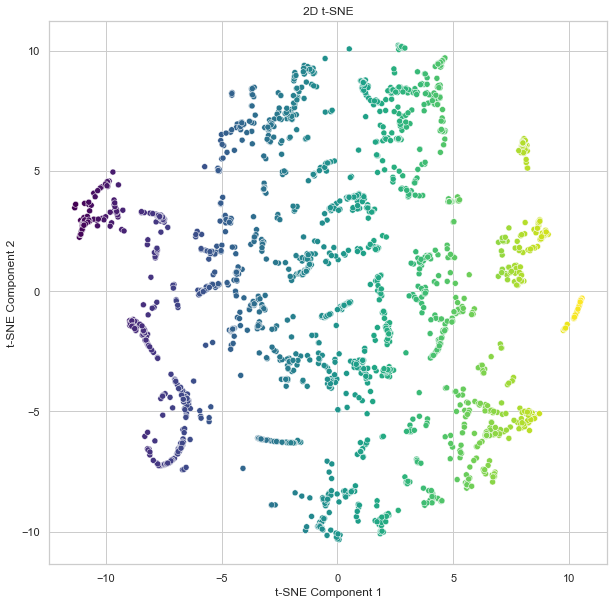

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2087 samples in 0.001s...
[t-SNE] Computed neighbors for 2087 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2087
[t-SNE] Computed conditional probabilities for sample 2000 / 2087
[t-SNE] Computed conditional probabilities for sample 2087 / 2087
[t-SNE] Mean sigma: 0.850824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.088379
[t-SNE] KL divergence after 300 iterations: 1.122020


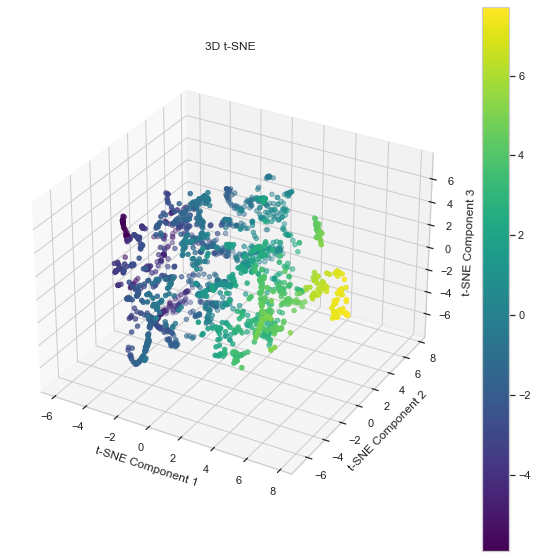

In [18]:
def scale_data(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

def pca_2d_visualization(df_scaled):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df_scaled)
    PCA_dataset = pd.DataFrame(data=principalComponents, columns=['component1', 'component2'])
    plt.figure(figsize=(10, 10))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2 Component PCA')
    sns.scatterplot(x='component1', y='component2', data=PCA_dataset, palette='viridis', hue='component1', legend=False)
    plt.show()

def tsne_2d_visualization(df_scaled, perplexity=40, n_iter=300):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(df_scaled)
    TSNE_dataset = pd.DataFrame(data=tsne_results, columns=['tsne_component1', 'tsne_component2'])
    plt.figure(figsize=(10, 10))
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('2D t-SNE')
    sns.scatterplot(x='tsne_component1', y='tsne_component2', data=TSNE_dataset, palette='viridis', hue='tsne_component1', legend=False)
    plt.show()

def tsne_3d_visualization(df_scaled, perplexity=40, n_iter=300):
    tsne = TSNE(n_components=3, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(df_scaled)
    TSNE_dataset = pd.DataFrame(data=tsne_results, columns=['tsne_component1', 'tsne_component2', 'tsne_component3'])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('3D t-SNE')
    scatter = ax.scatter(xs=TSNE_dataset['tsne_component1'],
                         ys=TSNE_dataset['tsne_component2'],
                         zs=TSNE_dataset['tsne_component3'],
                         c=TSNE_dataset['tsne_component1'],
                         cmap='viridis')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    plt.colorbar(scatter)
    plt.show()
df_scaled = scale_data(df)
pca_2d_visualization(df_scaled)
tsne_2d_visualization(df_scaled)
tsne_3d_visualization(df_scaled)


Spectral Clusteing

Silhouette Score: 0.5966
Davies-Bouldin Index: 0.7053
Calinski-Harabasz Index: 2706.5309


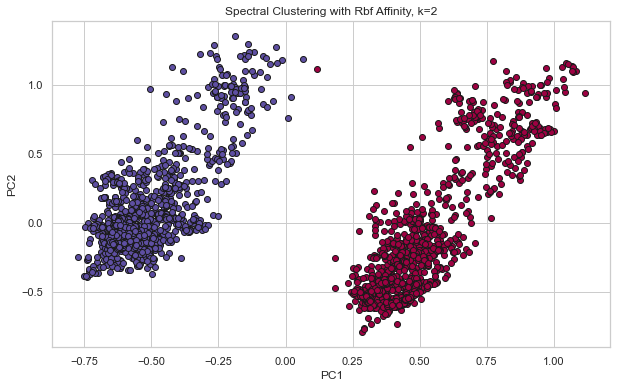

Silhouette Score: 0.6628
Davies-Bouldin Index: 0.4767
Calinski-Harabasz Index: 4027.3962


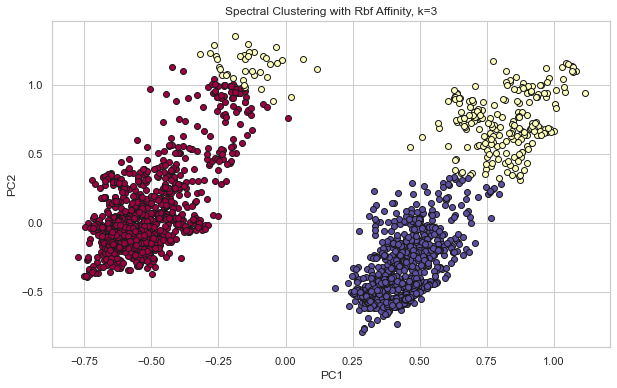

C:\Users\mkami\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


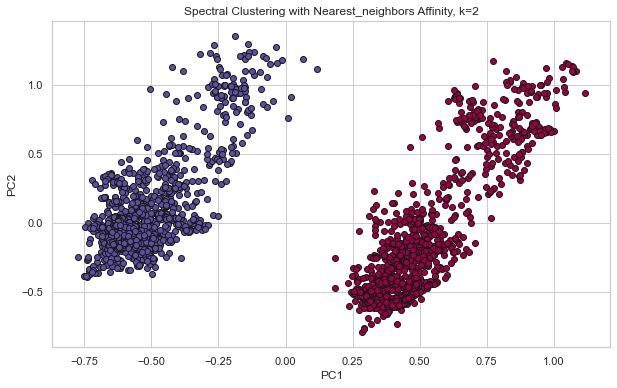

C:\Users\mkami\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score: 0.6479
Davies-Bouldin Index: 0.4651
Calinski-Harabasz Index: 3737.1635


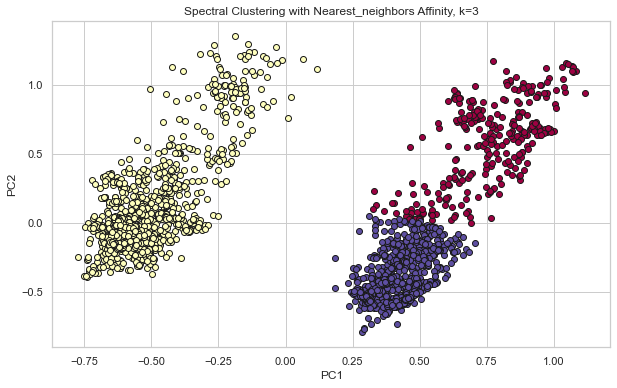

In [19]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_selection(df):
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    return pca_df

def apply_spectral_clustering(pca_df, n_clusters, affinity_type, pc1='PC1', pc2='PC2'):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity=affinity_type, random_state=123)
    clusters = spectral.fit_predict(pca_df[[pc1, pc2]])

    pca_df['Cluster'] = clusters

    silhouette_avg = silhouette_score(pca_df[[pc1, pc2]], clusters)
    db_index = davies_bouldin_score(pca_df[[pc1, pc2]], clusters)
    ch_index = calinski_harabasz_score(pca_df[[pc1, pc2]], clusters)

    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}")

    plt.figure(figsize=(10, 6))
    unique_clusters = np.unique(clusters)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    for k, col in zip(unique_clusters, colors):
        class_member_mask = (clusters == k)
        xy = pca_df[class_member_mask]
        plt.plot(xy[pc1], xy[pc2], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title(f'Spectral Clustering with {affinity_type.capitalize()} Affinity, k={n_clusters}')
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.grid(True)
    plt.show()

# Example dataframe
# df = pd.read_csv("your_data.csv")  # Assuming your dataset is loaded here

pca_df = pca_selection(df)

apply_spectral_clustering(pca_df, n_clusters=2, affinity_type='rbf')
apply_spectral_clustering(pca_df, n_clusters=3, affinity_type='rbf')

apply_spectral_clustering(pca_df, n_clusters=2, affinity_type='nearest_neighbors')
apply_spectral_clustering(pca_df, n_clusters=3, affinity_type='nearest_neighbors')


In [19]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_selection(df):
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    return pca_df

def apply_spectral_clustering(pca_df, n_clusters, affinity_type, pc1='PC1', pc2='PC2'):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity=affinity_type, random_state=123)
    clusters = spectral.fit_predict(pca_df[[pc1, pc2]])

    pca_df['Cluster'] = clusters

    silhouette_avg = silhouette_score(pca_df[[pc1, pc2]], clusters)
    db_index = davies_bouldin_score(pca_df[[pc1, pc2]], clusters)
    ch_index = calinski_harabasz_score(pca_df[[pc1, pc2]], clusters)

    results = {
        'Affinity': affinity_type,
        'n_clusters': n_clusters,
        'Silhouette Score': silhouette_avg,
        'Davies-Bouldin Index': db_index,
        'Calinski-Harabasz Index': ch_index
    }

    return results

def display_results_table(results_list):
    results_df = pd.DataFrame(results_list)
    print(results_df)

pca_df = pca_selection(df)

# Store results in a list
results_list = []

results_list.append(apply_spectral_clustering(pca_df, n_clusters=2, affinity_type='rbf'))
results_list.append(apply_spectral_clustering(pca_df, n_clusters=3, affinity_type='rbf'))
results_list.append(apply_spectral_clustering(pca_df, n_clusters=2, affinity_type='nearest_neighbors'))
results_list.append(apply_spectral_clustering(pca_df, n_clusters=3, affinity_type='nearest_neighbors'))

# Display the results in a tabular form
display_results_table(results_list)


            Affinity  n_clusters  Silhouette Score  Davies-Bouldin Index  \
0                rbf           2          0.596612              0.705302   
1                rbf           3          0.662825              0.476724   
2  nearest_neighbors           2          0.596782              0.705151   
3  nearest_neighbors           3          0.647901              0.465084   

   Calinski-Harabasz Index  
0              2706.530868  
1              4027.396204  
2              2709.611643  
3              3737.163467  


C:\Users\mkami\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


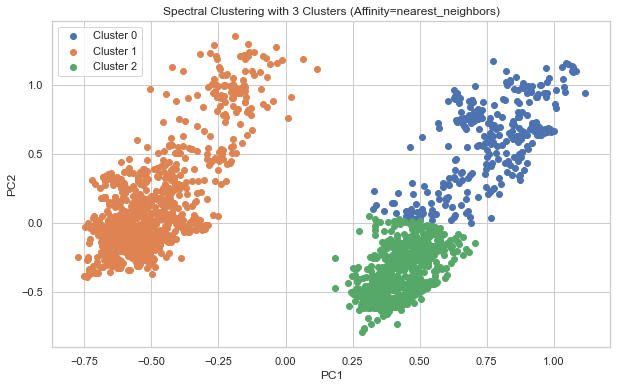

            Affinity  n_clusters  Silhouette Score  Davies-Bouldin Index  \
0  nearest_neighbors           3          0.647901              0.465084   

   Calinski-Harabasz Index  
0              3737.163467  


In [20]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_selection(df):
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    return pca_df

def apply_spectral_clustering(pca_df, n_clusters, affinity_type, pc1='PC1', pc2='PC2'):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity=affinity_type, random_state=123)
    clusters = spectral.fit_predict(pca_df[[pc1, pc2]])

    pca_df['Cluster'] = clusters

    silhouette_avg = silhouette_score(pca_df[[pc1, pc2]], clusters)
    db_index = davies_bouldin_score(pca_df[[pc1, pc2]], clusters)
    ch_index = calinski_harabasz_score(pca_df[[pc1, pc2]], clusters)

    # Plotting the clusters
    plt.figure(figsize=(10, 6))
    for cluster in np.unique(clusters):
        cluster_data = pca_df[pca_df['Cluster'] == cluster]
        plt.scatter(cluster_data[pc1], cluster_data[pc2], label=f'Cluster {cluster}')

    plt.title(f'Spectral Clustering with {n_clusters} Clusters (Affinity={affinity_type})')
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.legend()
    plt.grid(True)
    plt.show()

    results = {
        'Affinity': affinity_type,
        'n_clusters': n_clusters,
        'Silhouette Score': silhouette_avg,
        'Davies-Bouldin Index': db_index,
        'Calinski-Harabasz Index': ch_index
    }

    return results

def display_results_table(results_list):
    results_df = pd.DataFrame(results_list)
    print(results_df)


pca_df = pca_selection(df)
results_list = []

results_list.append(apply_spectral_clustering(pca_df, n_clusters=3, affinity_type='nearest_neighbors'))

# Display the results in a tabular form
display_results_table(results_list)


In [21]:
from sklearn.cluster import SpectralClustering
import pandas as pd
def apply_spectral_clustering(df, n_clusters=3, affinity='nearest_neighbors'):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity=affinity, random_state=123)

    # Applying Spectral Clustering to the dataset
    df['Spectral_Cluster'] = spectral.fit_predict(df)

    return df

df = apply_spectral_clustering(df, n_clusters=3, affinity='nearest_neighbors')


C:\Users\mkami\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


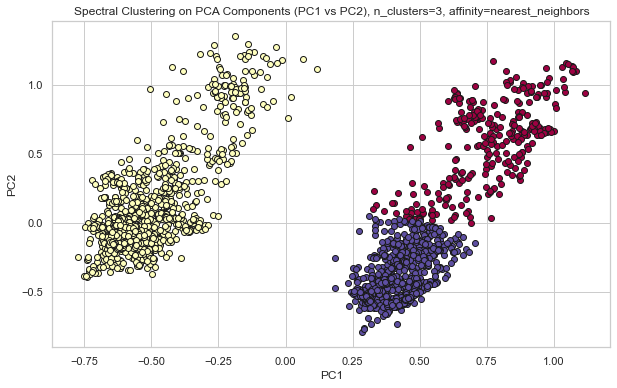

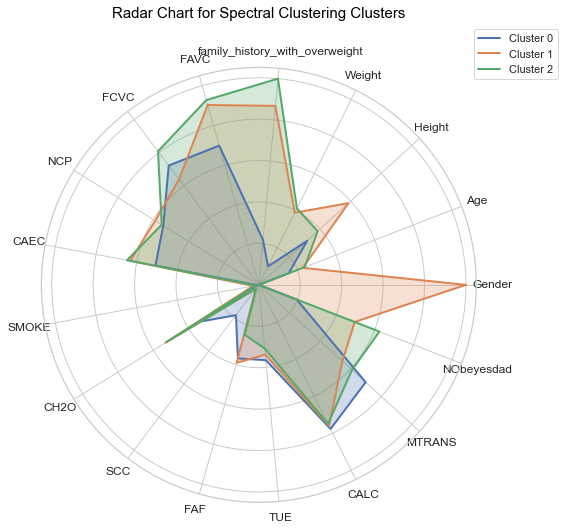

In [22]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Create a copy of df for clustering operations
df1 = df.copy()

# Apply Spectral Clustering and calculate evaluation metrics
def apply_spectral_on_pca(pca_df, n_clusters_value, affinity_type='nearest_neighbors', pc1='PC1', pc2='PC2'):
    spectral = SpectralClustering(n_clusters=n_clusters_value, affinity=affinity_type, random_state=123)
    clusters = spectral.fit_predict(pca_df[[pc1, pc2]])

    # Add the cluster labels to the PCA DataFrame
    pca_df['Cluster'] = clusters


    plt.figure(figsize=(10, 6))
    unique_clusters = np.unique(clusters)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    for k, col in zip(unique_clusters, colors):
        class_member_mask = (clusters == k)
        xy = pca_df[class_member_mask]
        plt.plot(xy[pc1], xy[pc2], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title(f'Spectral Clustering on PCA Components ({pc1} vs {pc2}), n_clusters={n_clusters_value}, affinity={affinity_type}')
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.grid(True)
    plt.show()

    # Return the cluster labels
    return clusters

clusters = apply_spectral_on_pca(pca_df, n_clusters_value=3, affinity_type='nearest_neighbors')
df1['Spectral_Cluster'] = clusters  # Add the cluster labels as a new column in df1

# Function to create a radar chart for a given cluster type
def plot_radar_chart(df, cluster_column, title='Radar Chart'):
    # Calculate the mean of each feature by cluster
    cluster_means = df.groupby(cluster_column).mean()

    # Define labels (features) and number of variables
    labels = cluster_means.columns
    num_vars = len(labels)

    # Setup angles for radar chart (spaced equally around a circle)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot needs to be a complete loop, so we repeat the first angle at the end
    angles += angles[:1]

    # Plotting radar chart for each cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each cluster
    for idx, row in cluster_means.iterrows():
        values = row.tolist()
        values += values[:1]  # Complete the loop by adding the start value at the end
        ax.plot(angles, values, label=f'Cluster {idx}', linewidth=2)
        ax.fill(angles, values, alpha=0.25)

    # Set up chart attributes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels([])
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

    plt.show()

# Radar chart for Spectral Clustering clusters
plot_radar_chart(df1, 'Spectral_Cluster', title='Radar Chart for Spectral Clustering Clusters')


**AFFINITY PROPAGATION**

In [23]:
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# Ensure 'df' is numerical only and convert to NumPy for speed
numerical_df = df.select_dtypes(include=[np.number])
scaled_df = StandardScaler().fit_transform(numerical_df)

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(scaled_df)

# Create PCA dataframe
pca_df = pd.DataFrame(data=principal_comp, columns=['pca1', 'pca2'])

def run_affinity_propagation(damping, data):
    model = AffinityPropagation(damping=damping, random_state=5)
    model.fit(data)
    return model.labels_

# List of damping values
damping_values = [0.5, 0.9]

# Run clustering in parallel
cluster_labels = Parallel(n_jobs=-1)(
    delayed(run_affinity_propagation)(damping, scaled_df) for damping in damping_values
)

# Add cluster labels to PCA dataframe
for i, damping in enumerate(damping_values):
    pca_df[f'cluster_{int(damping * 10):02}'] = cluster_labels[i]

# Display results
print("Unique cluster labels (damping=0.5):", np.unique(pca_df['cluster_05']))
print("Unique cluster labels (damping=0.9):", np.unique(pca_df['cluster_09']))
print(pca_df.head())


Unique cluster labels (damping=0.5): [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139]
Unique cluster labels (damping=0.9): [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87 

<ipython-input-28-66b899b6df88>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('viridis', len(np.unique(pca_df[f'cluster_{int(damping * 10):02}']))),


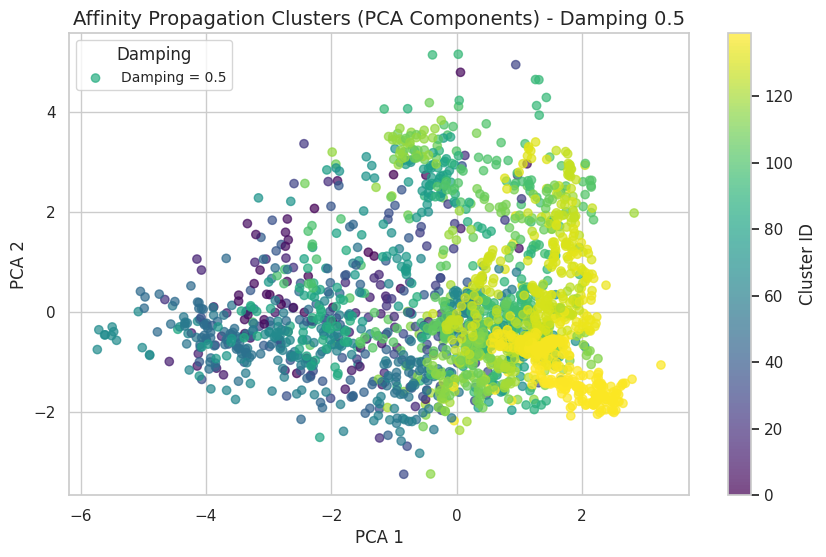

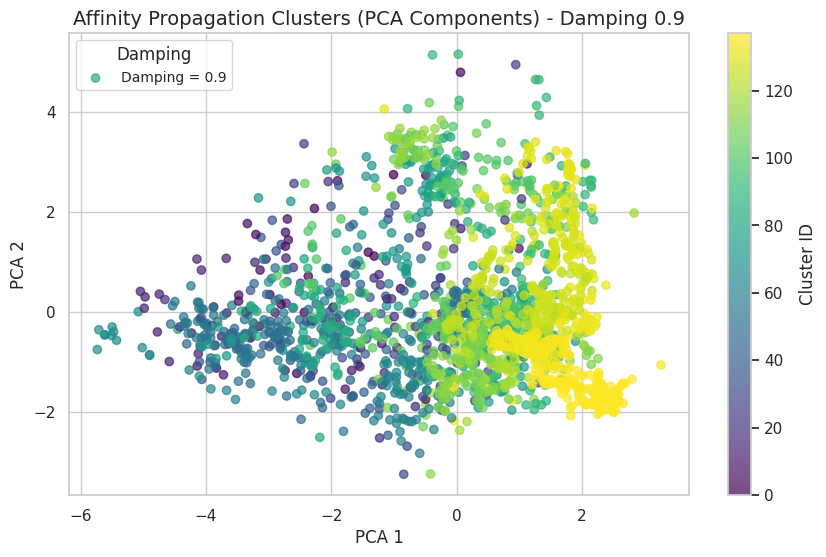

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define damping values for 0.5 and 0.9
damping_values = [0.5, 0.9]

def plot_affinity_propagation_clusters_separately(pca_df, damping_values):
    # Loop over the damping values and create separate plots
    for damping in damping_values:
        # Set up the figure for each damping value
        plt.figure(figsize=(10, 6))

        # Create a scatter plot for the current damping value
        plt.scatter(
            pca_df['pca1'], pca_df['pca2'],
            c=pca_df[f'cluster_{int(damping * 10):02}'],
            cmap=plt.cm.get_cmap('viridis', len(np.unique(pca_df[f'cluster_{int(damping * 10):02}']))),
            label=f'Damping = {damping}', alpha=0.7
        )

        # Title and labels for each plot
        plt.title(f'Affinity Propagation Clusters (PCA Components) - Damping {damping}', fontsize=14)
        plt.xlabel('PCA 1', fontsize=12)
        plt.ylabel('PCA 2', fontsize=12)
        plt.legend(title='Damping', fontsize=10)

        # Show the plot
        plt.colorbar(label='Cluster ID')
        plt.grid(True)
        plt.show()

# Assuming `pca_df` is your PCA DataFrame with clustering results
# Call the plotting function to show separate plots for damping values 0.5 and 0.9
plot_affinity_propagation_clusters_separately(pca_df, damping_values)
